### Third step: PRETRAINED CONVNET (continued)
To begin, we'll use a VGG16 architecture, a simple a widely used convnet architecture for ImageNet (a dataset whit 1.4 million labeled images and 1000 diferent classes).

How to use a pretrained network?
- feature extraction 
    - Fast feature extraction without data augmentation-> (in 07_Convnet_DogsVSCats_3.ipynb)
    - **Feature extraction with data augmentation**
- **fine-tuning** -> (at the end)

#### Feature extraction with data augmentation
Slower and more expensive, but allows data augmentation. Consists of extending the ```conv_base``` model and running it end to end on the inputs. **ONLY FOR GPUS**

In [1]:
import os

base_dir = '/tf/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [9]:
# To instastiate the VGG16 model
from tensorflow.keras.applications import VGG16

# Construct the model
from keras import models
from keras import layers

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

# To plot results
import matplotlib.pyplot as plt

In [3]:
conv_base = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 9s 0us/step


In [15]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

The convolutional base of VGG16 has 14,714,688 parameters, which is *very large*. The classifier you’re adding on top has 2 million parameters.

#### Freezing
**Before** compiling and training the model, it’s very important to freeze the convolutional base. Freezing a layer (or a set of) layers means preventing their weights from being updated during training. Otherwise, the representations that were previously learned by the convolutional base will be destroyed during training.

In [5]:
conv_base.trainable = False

In [6]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

# The validation data shouldn't be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150, 150),
                    batch_size=20,
                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                    validation_dir,
                    target_size=(150, 150),
                    batch_size=20,
                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=2e-5),
                metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [8]:
history = model.fit(
            train_generator,
            steps_per_epoch=100,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=50)

Epoch 1/30
100/100 [==============================] - 11s 97ms/step - loss: 0.5842 - acc: 0.7045 - val_loss: 0.4630 - val_acc: 0.8090
Epoch 2/30
100/100 [==============================] - 10s 96ms/step - loss: 0.4861 - acc: 0.7790 - val_loss: 0.3711 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 10s 96ms/step - loss: 0.4381 - acc: 0.8050 - val_loss: 0.3304 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 10s 96ms/step - loss: 0.4038 - acc: 0.8275 - val_loss: 0.3133 - val_acc: 0.8680
Epoch 5/30
100/100 [==============================] - 10s 96ms/step - loss: 0.3835 - acc: 0.8335 - val_loss: 0.2964 - val_acc: 0.8770
Epoch 6/30
100/100 [==============================] - 10s 96ms/step - loss: 0.3671 - acc: 0.8330 - val_loss: 0.2862 - val_acc: 0.8800
Epoch 7/30
100/100 [==============================] - 10s 96ms/step - loss: 0.3543 - acc: 0.8440 - val_loss: 0.2735 - val_acc: 0.8890
Epoch 8/30
100/100 [==============================] - 10s 96ms

#### Plotting the results

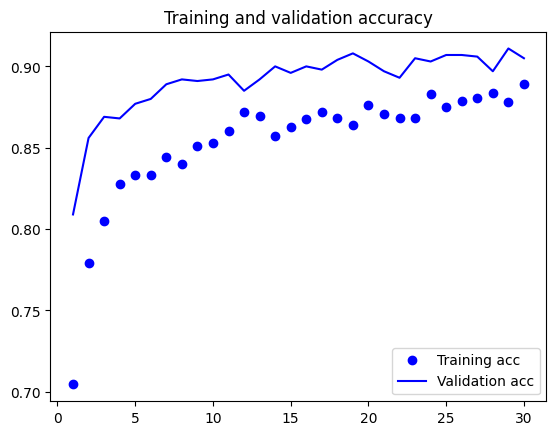

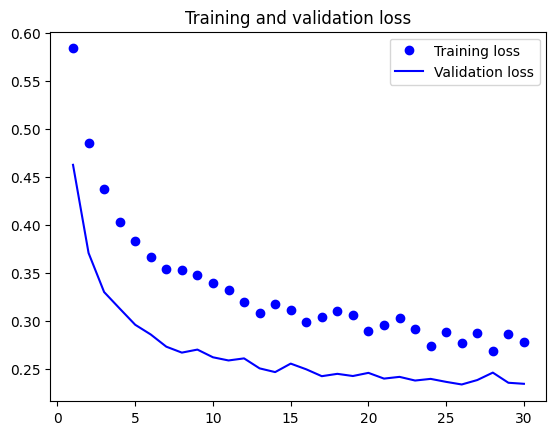

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine tuning
it’s necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it’s only
possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained.

**STEPS:**
- Add your custom network on top of an already-trained base network.
- Freeze the base network.
- Train the part you added.
- Unfreeze some layers in the base network.
- Jointly train both these layers and the part you added.

Feature-extraction with data augmentation does the first 3 steps!

Then, step 4 is :

In [17]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Step 5, the fine tuning per se, uses the RMSProp optimizer with a very low ```learning_rate```, so not to harm the representations learned by the reused base.

In [18]:
model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-5),
                metrics=['acc'])

In [19]:
history = model.fit(
                train_generator,
                steps_per_epoch=100,
                epochs=30,
                validation_data=validation_generator,
                validation_steps=50)

Epoch 1/30
100/100 [==============================] - 10s 98ms/step - loss: 0.4556 - acc: 0.7890 - val_loss: 0.2493 - val_acc: 0.8990
Epoch 2/30
100/100 [==============================] - 10s 96ms/step - loss: 0.2729 - acc: 0.8860 - val_loss: 0.2270 - val_acc: 0.9060
Epoch 3/30
100/100 [==============================] - 10s 98ms/step - loss: 0.2344 - acc: 0.9050 - val_loss: 0.1962 - val_acc: 0.9180
Epoch 4/30
100/100 [==============================] - 10s 96ms/step - loss: 0.2163 - acc: 0.9090 - val_loss: 0.1870 - val_acc: 0.9150
Epoch 5/30
100/100 [==============================] - 10s 96ms/step - loss: 0.2006 - acc: 0.9165 - val_loss: 0.1672 - val_acc: 0.9310
Epoch 6/30
100/100 [==============================] - 10s 96ms/step - loss: 0.1917 - acc: 0.9220 - val_loss: 0.2002 - val_acc: 0.9230
Epoch 7/30
100/100 [==============================] - 10s 97ms/step - loss: 0.1800 - acc: 0.9265 - val_loss: 0.2221 - val_acc: 0.9130
Epoch 8/30
100/100 [==============================] - 10s 97ms

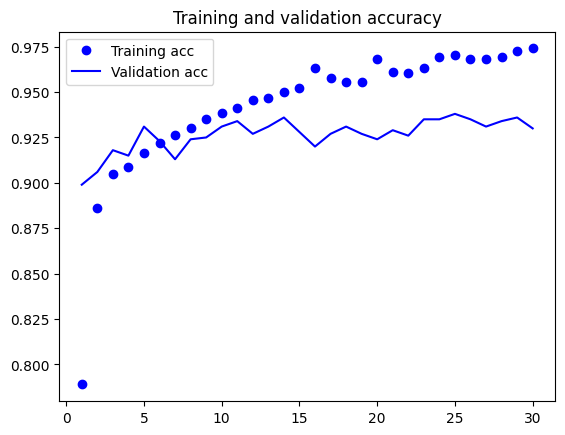

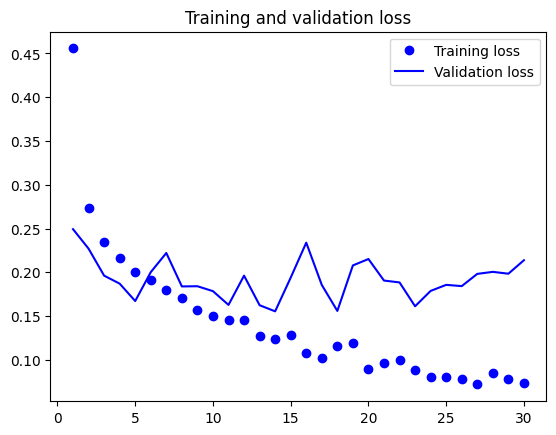

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

To smooth the curves:

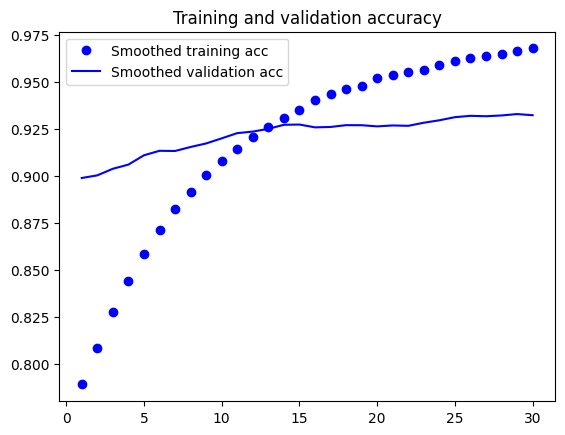

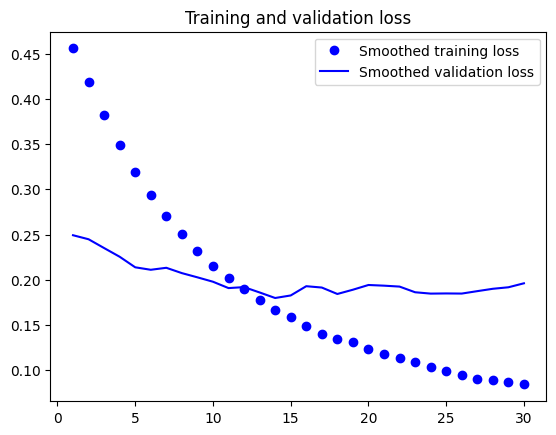

In [21]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### How could accuracy stay stable or improve if the loss isn’t decreasing?
Sometimes, the loss curve doesn't show any real improvement. The answer is simple: what we display is an average of pointwise loss values; but what matters for accuracy is the *distribution of the loss values, not their average*, because ***accuracy is the result of a binary thresholding of the class probability predicted by the model***. The model may still be improving even if this isn’t reflected in the average loss.